In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, shape, Point
import pyproj
from functools import partial
from shapely.ops import transform
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model
from sklearn import svm


%matplotlib inline

In [3]:
import pyproj
from functools import partial
from shapely.ops import transform


In [4]:
cost_paths_cars = pd.read_csv('cost_paths_cars.csv')
cost_paths_cars = cost_paths_cars.drop(columns = ['Unnamed: 0'])
cost_paths_cars.head()

,row_id,first,last,cat1,cost_f
0,2,10000,10006,6.500,0.34
1,3,10000,3550308074,6.000,0.54
2,4,10000,3550308092,40.767,0.54
3,5,10000,3550308073,21.400,0.42
4,6,10000,3550308088,21.700,0.32


In [6]:
equips_map = gpd.read_file('../pacote_USP/equips.shp')
equips_map.head()

,id2,id,dscrptn,sentido,x,y,geometry
0,10000,10000,"Sao Paulo - R Domingos De Morais, 2.329 - Sent...",centro,-46.63649,-23.59656,POINT (-46.63649 -23.59655999999921)
1,10001,10001,Itapecerica Da Serra - Sp-228 - Km 29 + 200 - ...,leste,-46.82645,-23.69856,POINT (-46.82644999999999 -23.69855999999919)
2,10003,10003,Itupeva - Sp-300 - Rod Dom Gabriel Paulimo Bue...,leste,-47.04259,-23.23534,POINT (-47.04258999999999 -23.23533999999919)
3,10006,10006,Sao Paulo - Av Nove De Julho X R Paim - Sent A...,None,-46.64875,-23.55459,POINT (-46.64874999999999 -23.55458999999921)
4,10007,10007,"Taboao Da Serra - Est Kizaemon Takeuti, 286 - ...",bairro,-46.78032,-23.63451,POINT (-46.78031999999998 -23.63450999999921)


In [7]:
equips_map.crs

{'init': 'epsg:4326'}

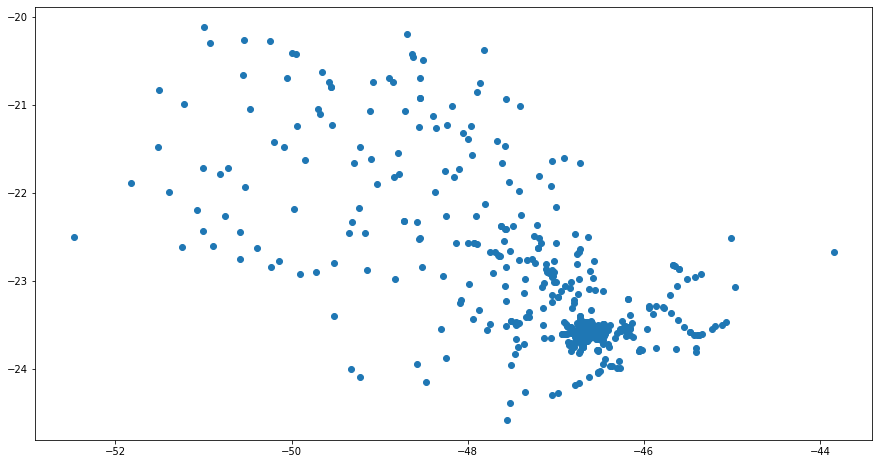

In [8]:
fig,ax = plt.subplots(figsize = (15,15))
equips_map.plot(ax=ax);

In [9]:
def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
            elif p.geom_type == 'MultiPolygon':
                new_multi_p = []
                for ap in p:
                    lines = [xy[:2] for xy in list(ap.exterior.coords)]
                    new_p = Polygon(lines)
                    new_multi_p.append(new_p)
                new_geo.append(MultiPolygon(new_multi_p))
    return new_geo

In [35]:
sp_zones = gpd.read_file('../Shape/Zonas_2017_region.shp')
#sp_zones = sp_zones[sp_zones.NomeMunici == 'São Paulo']
sp_zones.crs = {'init': 'epsg:22523'}
sp_zones = sp_zones.to_crs({'init': 'epsg:4326'})
sp_zones['centroid_geometry'] = sp_zones['geometry'].centroid
points =sp_zones.drop(columns = ['geometry']).rename(columns={'centroid_geometry':'geometry'})
points['lat'] = points['geometry'].y
points['lon'] = points['geometry'].x

points.head()

,NumeroZona,NomeZona,NumeroMuni,NomeMunici,NumDistrit,NomeDistri,Area_ha_2,geometry,lat,lon
0,1,Sé,36,São Paulo,80,Sé,57.10,POINT (-46.63392282742884 -23.54884608104086),-23.548846,-46.633923
1,2,Parque Dom Pedro,36,São Paulo,80,Sé,113.64,POINT (-46.62976022091731 -23.54413673886143),-23.544137,-46.629760
2,3,Praça João Mendes,36,São Paulo,80,Sé,47.75,POINT (-46.63259422462883 -23.55408913897663),-23.554089,-46.632594
3,4,Ladeira da Memória,36,São Paulo,67,República,75.11,POINT (-46.64178414600227 -23.55152712919663),-23.551527,-46.641784
4,5,República,36,São Paulo,67,República,74.95,POINT (-46.64294729555171 -23.54440043629242),-23.544400,-46.642947


In [36]:
points.to_excel("centroids.xlsx", engine='xlsxwriter')

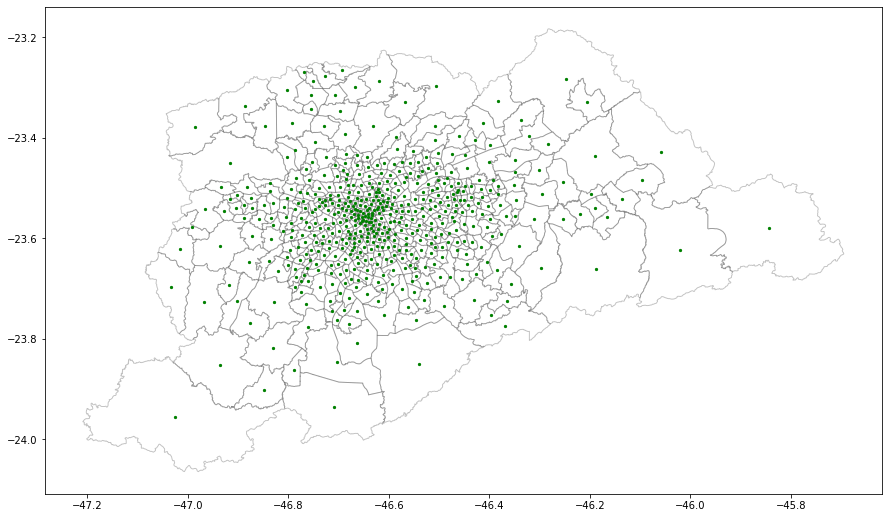

In [33]:
fig,ax = plt.subplots(figsize = (15,15))
sp_zones.plot(ax=ax, color = 'white', alpha = 0.25, linewidth=0.95, edgecolor='0.05',);
points.plot(ax=ax, markersize=5, color= 'green', marker ='o', label = 'Centroid');


In [11]:
equips_within_zones = gpd.sjoin(equips_map, sp_zones, how="inner", op='intersects')
equips_within_zones = equips_within_zones[['id','geometry','NumeroZona']]
equips_within_zones.head()

,id,geometry,NumeroZona
0,10000,POINT (-46.63649 -23.59655999999921),53
59,10146,POINT (-46.62982 -23.5931999999992),53
3,10006,POINT (-46.64874999999999 -23.55458999999921),25
9,10013,POINT (-46.65844999999999 -23.5320199999992),36
481,11486,POINT (-46.66197999999999 -23.5342399999992),36


In [12]:
equips_merged = pd.merge(cost_paths_cars,equips_within_zones, how = 'inner', left_on = 'last', \
                         right_on = 'id', right_index = False, left_index = False
                        )
equips_merged = equips_merged.rename(columns = { 'first':'fid', \
                                                'last':'lid','cat1':'vol', \
                                                'NumeroZona':'lzone'})[['geometry','fid','lid','vol','lzone','cost_f']]
equips_merged.head()

,geometry,fid,lid,vol,lzone,cost_f
0,POINT (-46.64874999999999 -23.55458999999921),10000,10006,6.500,25,0.34
1,POINT (-46.64874999999999 -23.55458999999921),10007,10006,0.300,25,0.63
2,POINT (-46.64874999999999 -23.55458999999921),10009,10006,2.867,25,0.52
3,POINT (-46.64874999999999 -23.55458999999921),10012,10006,0.767,25,1.29
4,POINT (-46.64874999999999 -23.55458999999921),10013,10006,1.133,25,0.17


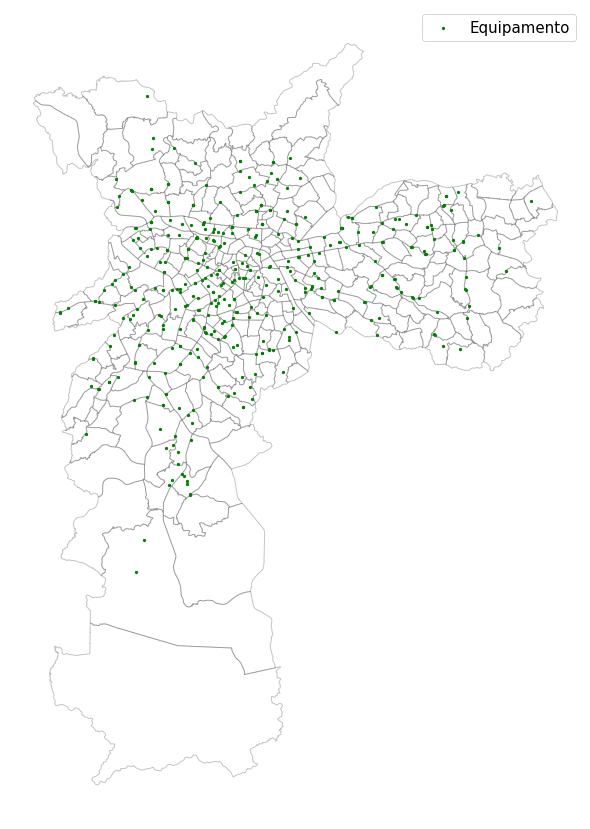

In [13]:
fig,ax = plt.subplots(figsize = (15,15))
sp_zones.plot(ax=ax, color = 'white', alpha = 0.25, linewidth=0.95, edgecolor='0.05',);
equips_within_zones.plot(ax=ax, markersize=5, color= 'green', marker ='o', label = 'Equipamento');
plt.axis('off');
plt.legend(prop = {'size' : 15});

In [14]:
od_survey = pd.read_csv('../pesquisa_OD.csv', sep =';').dropna(how = 'all').replace('-',0)

od_survey

,zona,nome,municipio,domicilios,familias,populacao,matriculas,empregos,automoveis,viagens_produzidas,...,atr_motivo_trabalho_industria,atr_motivo_trabalho_comercio,atr_motivo_trabalho_servcos,atr_motivo_educacao,atr_motivo_compras,atr_motivo_saude,atr_motivo_lazer,atr_motivo_procurar_emprego,atr_motivo_assuntos_pessoais,atr_motivo_refeicao
0,1.0,Sé,São Paulo,1151.0,1151.0,3262.0,6363.2,71852.3,325.5,160502.9,...,1591.1,11034.7,88679.9,6998.7,6750.8,1417.9,3221.6,3124.9,20311.7,17026.1
1,2.0,Parque Dom Pedro,São Paulo,2342.0,2342.0,5695.0,1433.3,51853.7,890.7,137231.7,...,2260.2,32580.2,38486.6,4438.0,37999.0,1537.4,2301.9,1260.9,10889.1,6553.2
2,3.0,Praça João Mendes,São Paulo,7100.0,7100.0,17130.0,2398.5,18547.3,1166.0,62971.0,...,1604.0,3712.9,29270.3,8727.1,3510.7,2695.8,1747.4,169.8,5893.7,5171.1
3,4.0,Ladeira da Memória,São Paulo,12588.0,12588.0,24089.0,1126.7,22553.9,3400.9,78184.0,...,277.5,3886.7,35275.2,8028.4,2822.2,3420.2,5508.8,370.0,15042.7,3653.9
4,5.0,República,São Paulo,8050.0,8050.0,14956.0,1726.9,89486.7,1737.3,186219.6,...,2606.1,22966.3,108022.3,6402.6,3979.4,3410.3,5459.4,5248.9,14165.1,14892.2
5,6.0,Santa Ifigênia,São Paulo,9411.0,9411.0,21989.0,2039.1,38371.9,1445.1,109791.2,...,2227.8,27707.4,35720.8,12881.6,9010.5,1977.9,1380.8,0.0,7556.9,10886.8
6,7.0,Luz,São Paulo,6342.0,6342.0,18210.0,6873.5,35047.9,2400.9,93161.0,...,8611.9,23407.4,23881.6,14545.8,10249.2,689.0,3900.2,0.0,4871.0,3524.4
7,8.0,Bom Retiro,São Paulo,3834.0,4110.7,12252.0,3280.3,15080.2,1747.9,40222.7,...,5988.8,3965.6,12808.1,12945.5,881.3,313.5,1169.8,267.5,1231.9,598.0
8,9.0,Ponte Pequena,São Paulo,2267.0,2267.0,7456.0,6413.2,16492.4,486.6,36268.8,...,3602.8,2817.4,13634.9,9670.7,818.0,331.3,649.0,476.6,4321.4,199.8
9,10.0,Canindé,São Paulo,467.0,467.0,1619.0,7047.9,6712.8,134.0,23890.0,...,1537.7,2036.5,4705.0,9058.7,38.3,217.3,5435.0,0.0,377.3,624.6


In [15]:
equips_zones_data = pd.merge(equips_merged,od_survey, how = 'inner', left_on = 'lzone', \
                         right_on = 'zona', right_index = False, left_index = False
                        )

equips_zones_data

,geometry,fid,lid,vol,lzone,cost_f,zona,nome,municipio,domicilios,...,atr_motivo_trabalho_industria,atr_motivo_trabalho_comercio,atr_motivo_trabalho_servcos,atr_motivo_educacao,atr_motivo_compras,atr_motivo_saude,atr_motivo_lazer,atr_motivo_procurar_emprego,atr_motivo_assuntos_pessoais,atr_motivo_refeicao
0,POINT (-46.64874999999999 -23.55458999999921),10000,10006,6.500,25,0.34,25.0,Treze de Maio,São Paulo,7996.0,...,1956.8,1345.7,19550.9,11491.3,1789.2,656.5,1842.3,0.0,1305.0,891.8
1,POINT (-46.64874999999999 -23.55458999999921),10007,10006,0.300,25,0.63,25.0,Treze de Maio,São Paulo,7996.0,...,1956.8,1345.7,19550.9,11491.3,1789.2,656.5,1842.3,0.0,1305.0,891.8
2,POINT (-46.64874999999999 -23.55458999999921),10009,10006,2.867,25,0.52,25.0,Treze de Maio,São Paulo,7996.0,...,1956.8,1345.7,19550.9,11491.3,1789.2,656.5,1842.3,0.0,1305.0,891.8
3,POINT (-46.64874999999999 -23.55458999999921),10012,10006,0.767,25,1.29,25.0,Treze de Maio,São Paulo,7996.0,...,1956.8,1345.7,19550.9,11491.3,1789.2,656.5,1842.3,0.0,1305.0,891.8
4,POINT (-46.64874999999999 -23.55458999999921),10013,10006,1.133,25,0.17,25.0,Treze de Maio,São Paulo,7996.0,...,1956.8,1345.7,19550.9,11491.3,1789.2,656.5,1842.3,0.0,1305.0,891.8
5,POINT (-46.64874999999999 -23.55458999999921),10014,10006,0.633,25,0.45,25.0,Treze de Maio,São Paulo,7996.0,...,1956.8,1345.7,19550.9,11491.3,1789.2,656.5,1842.3,0.0,1305.0,891.8
6,POINT (-46.64874999999999 -23.55458999999921),10020,10006,0.333,25,4.69,25.0,Treze de Maio,São Paulo,7996.0,...,1956.8,1345.7,19550.9,11491.3,1789.2,656.5,1842.3,0.0,1305.0,891.8
7,POINT (-46.64874999999999 -23.55458999999921),10021,10006,1.767,25,0.68,25.0,Treze de Maio,São Paulo,7996.0,...,1956.8,1345.7,19550.9,11491.3,1789.2,656.5,1842.3,0.0,1305.0,891.8
8,POINT (-46.64874999999999 -23.55458999999921),10027,10006,9.233,25,0.26,25.0,Treze de Maio,São Paulo,7996.0,...,1956.8,1345.7,19550.9,11491.3,1789.2,656.5,1842.3,0.0,1305.0,891.8
9,POINT (-46.64874999999999 -23.55458999999921),10033,10006,0.267,25,0.46,25.0,Treze de Maio,São Paulo,7996.0,...,1956.8,1345.7,19550.9,11491.3,1789.2,656.5,1842.3,0.0,1305.0,891.8


In [52]:
n= 10083
equips_by_first = equips_zones_data[equips_zones_data.fid == n]

equips_by_first = equips_by_first.drop(columns = ['geometry','fid','lid','lzone','zona','nome','municipio'])

equips_by_first = equips_by_first.apply(pd.to_numeric, errors='ignore')

equips_by_first = equips_by_first[equips_by_first.vol > 0]


equips_by_first

corr = equips_by_first.corr()
corr_cols = list(corr['vol'].apply(lambda x : x if x > 0 else -x).sort_values(ascending=False)[1:11].index)
corr_cols

['cost_f',
 ' empregos_por_vinculo_empregaticio_funcionario_publico ',
 ' t_viagem_coletivo ',
 'emprego_serviço_administracao_publica',
 ' autonomo ',
 'atr_motivo_educacao',
 'populacao',
 ' estudante ',
 'prod_motivo_educacao',
 ' assalariado_com_carteira ']

In [53]:
X = equips_by_first[corr_cols]
y = equips_by_first[['vol']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)




In [54]:
import numpy as np
from sklearn import linear_model
from sklearn import svm

classifiers = [
    svm.SVR(),
    linear_model.SGDRegressor(),
    linear_model.BayesianRidge(),
    linear_model.LassoLars(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.LinearRegression(normalize = True)]

trainingData    = X_train
trainingScores  = y_train
predictionData  = X_test

for item in classifiers:
    print(item)
    clf = item
    clf.fit(trainingData, trainingScores.values.ravel())
    predictionScore = clf.predict(predictionData)
    r2 = r2_score(y_test,predictionScore)
    print(r2)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
-0.1272736630149245
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
-1.546872505043831e+34
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)
-0.6667028722730906
LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          p

C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


-0.7047154391047008
PassiveAggressiveRegressor(C=1.0, average=False, early_stopping=False,
                           epsilon=0.1, fit_intercept=True,
                           loss='epsilon_insensitive', max_iter=1000,
                           n_iter_no_change=5, random_state=None, shuffle=True,
                           tol=0.001, validation_fraction=0.1, verbose=0,
                           warm_start=False)
-123.52056053575508
TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
                  max_subpopulation=10000, n_jobs=None, n_subsamples=None,
                  random_state=None, tol=0.001, verbose=False)
0.01682536525404177
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
-1.1646830466218794


In [45]:

trainingData    = X_train
trainingScores  = y_train
predictionData  = X_test


clf = linear_model.TheilSenRegressor()
clf.fit(trainingData, trainingScores.values.ravel())
predictionScore = clf.predict(predictionData)
r2 = r2_score(y_test,predictionScore)


In [55]:
m = pd.DataFrame(y_test)
m['vol_calc'] = predictionScore
m.head()

,vol,vol_calc
116990,27.467,22.279721
237906,0.367,12.124011
220776,0.533,16.647995
167311,2.133,13.076099
115822,1.267,24.331981


In [ ]:
#TODO Aplicar modelo
lm_model.coef_
